In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sktime.forecasting.model_selection import temporal_train_test_split

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [311]:
import warnings

warnings.filterwarnings('ignore')

Нужно сгенерировать синтетический временной ряд, построить модели для прогнозирования временного ряда с использованием различных алгоритмов, провести анализ результатов и оценить качество моделей.

# Генерация данных:

Сгенерируйте синтетический временной ряд, содержащий 1000 наблюдений, представляющий собой сумму синусоидальной функции, тренда и случайного шума.

**Разделение данных:**

Разделите временной ряд на тренировочную (80%) и тестовую (20%) выборки.


In [248]:
np.random.seed(42)

N = 1000
#df = pd.DataFrame(pd.date_range(start='1/1/2024', end='20/03/2024', periods=N).floor('D'), columns=['date_time'])
df = pd.DataFrame(pd.date_range(start='1/1/2020', freq='D', periods=N).floor('D'), columns=['date_time'])
noise = np.random.normal(0, 0.5, N)
X = np.linspace(0, 5, N)
sin_x = np.sin(2 * np.pi * X)
trend_random = np.random.randint(200, 1000)
# df['date_time'] = df['date_time'].dt.date
df['total_feature'] = np.round(noise + sin_x + trend_random, 2)

In [249]:
df.head()

,date_time,total_feature
0,2020-01-01,627.25
1,2020-01-02,626.96
2,2020-01-03,627.39
3,2020-01-04,627.86
4,2020-01-05,627.01


In [250]:
y_train, y_test = temporal_train_test_split(df, train_size=0.8)

# Визуализация данных:

Постройте график временного ряда, чтобы визуализировать синтетические данные.





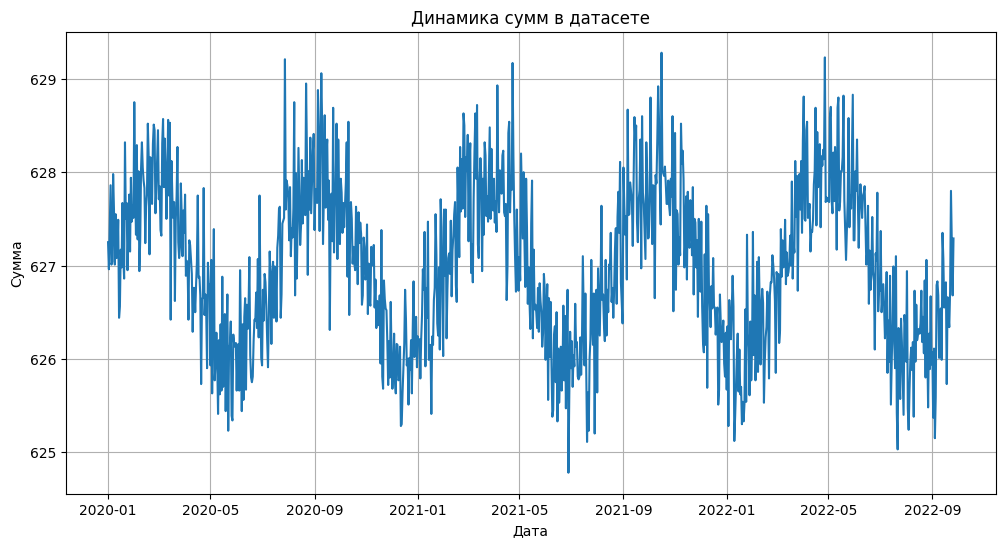

In [251]:
plt.figure(figsize=(12, 6))
plt.plot(df['date_time'], df['total_feature'], linestyle='-')

plt.title('Динамика сумм в датасете')
plt.xlabel('Дата')
plt.ylabel('Сумма')

plt.grid()
plt.show()

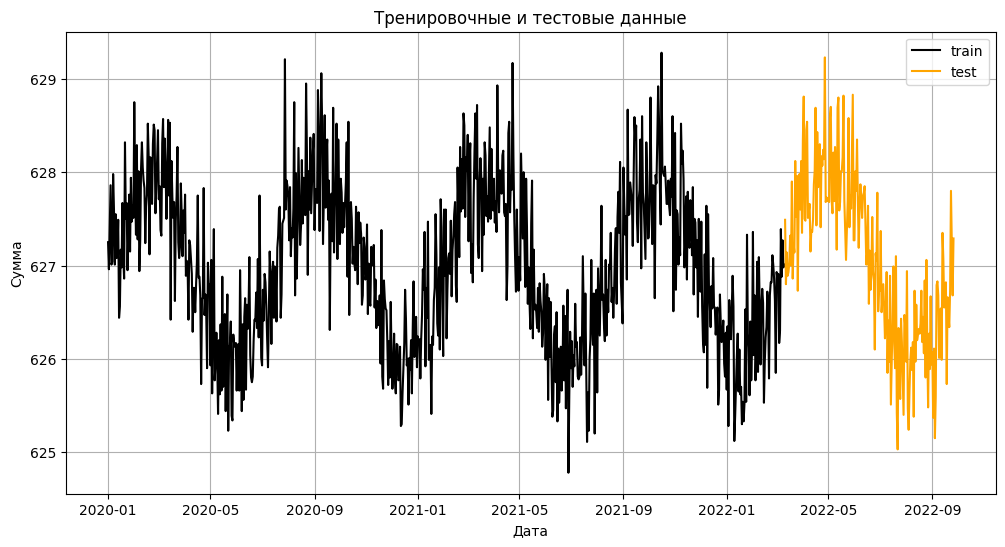

In [252]:
plt.figure(figsize=(12, 6))

plt.plot(y_train['date_time'], y_train['total_feature'], color='black', label='train', linestyle='-')
plt.plot(y_test['date_time'], y_test['total_feature'], color='orange', label='test', linestyle='-')

plt.title('Тренировочные и тестовые данные')
plt.xlabel('Дата')
plt.ylabel('Сумма')

plt.grid()
plt.legend()
plt.show()

# Построение моделей:

Постройте модели для прогнозирования временного ряда с использованием следующих алгоритмов:
    Автокорреляционная модель (AR)
    Модель экспоненциального сглаживания (ETS)



## Оценка качества моделей:

Оцените качество моделей на тестовой выборке с использованием метрик MAE (Mean Absolute Error) и RMSE (Root Mean Squared Error).

In [324]:
def calculate_mse(y_test, y_pred):
    return round(np.mean((y_test - y_pred) ** 2), 2)


def calculate_rmse(y_test, y_pred):
    return round(np.sqrt(np.mean((y_test - y_pred) ** 2)), 2)

## AutoReg

In [254]:
y_train.index = y_train['date_time']
y_test.index = y_test['date_time']

y_train = y_train.drop('date_time', axis=1)
y_test = y_test.drop('date_time', axis=1)

In [255]:
y_train.index = pd.DatetimeIndex(y_train.index, freq='D')
y_test.index = pd.DatetimeIndex(y_test.index, freq='D')

In [259]:
model = AutoReg(y_train, lags=10)
model_fit = model.fit()
y_pred = model_fit.predict(start=y_test.index[0], end=y_test.index[-1])

In [260]:
y_pred = pd.DataFrame(y_pred, columns=['total_feature'])
y_pred.head()

,total_feature
2022-03-11,626.927017
2022-03-12,626.911442
2022-03-13,626.927032
2022-03-14,626.861947
2022-03-15,626.963759


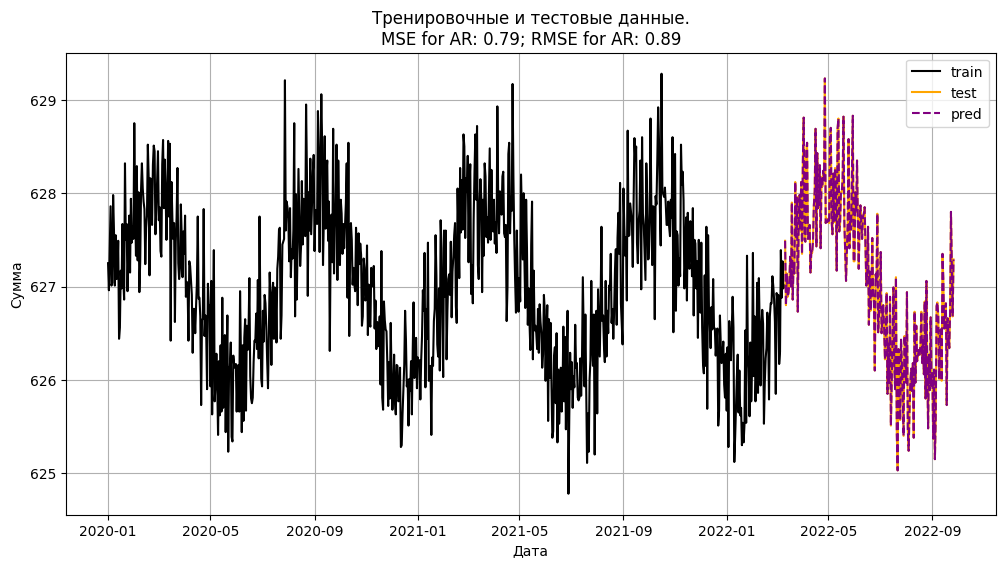

In [332]:
plt.figure(figsize=(12, 6))

plt.plot(y_train.index, y_train['total_feature'], color='black', label='train', linestyle='-')
plt.plot(y_test.index, y_test['total_feature'], color='orange', label='test', linestyle='-')
plt.plot(y_pred.index, y_test['total_feature'], color='purple', label='pred', linestyle='--')

plt.title(f'Тренировочные и тестовые данные.\nMSE for AR: {calculate_mse(y_test, y_pred)}; RMSE for AR: {calculate_rmse(y_test, y_pred)}')
plt.xlabel('Дата')
plt.ylabel('Сумма')

plt.grid()
plt.legend()
plt.show()

## ETS

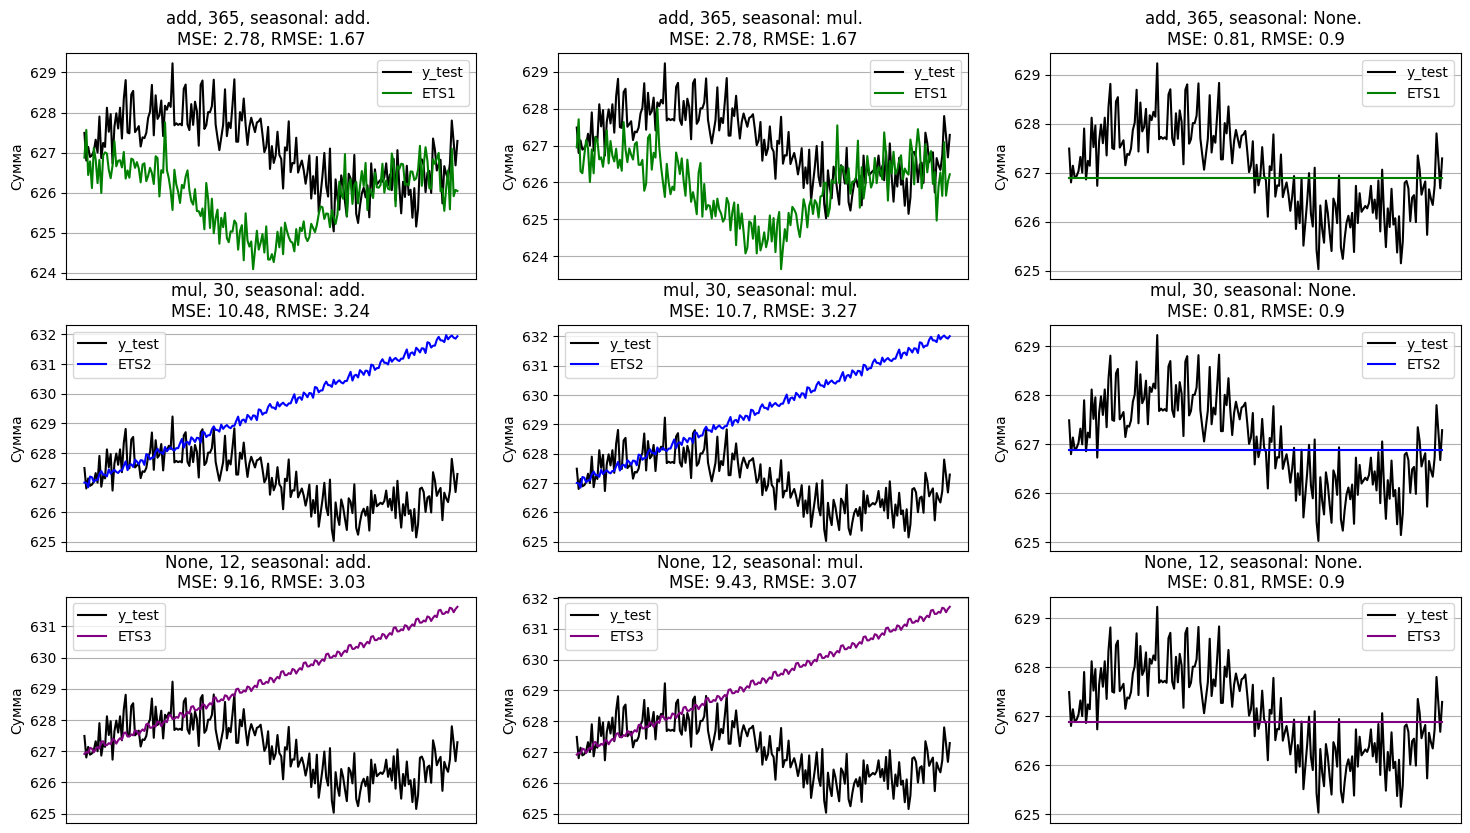

In [333]:
plt.figure(figsize=(18, 10))

lst = ['add', 'mul', None]
col = ['green', 'blue', 'purple']
period = [365, 30, 12]

for i,v in enumerate(lst):
    for j,k in enumerate(period):
        model_ETS = ExponentialSmoothing(y_train, trend=lst[j], seasonal=lst[j], seasonal_periods=period[i]).fit()
        forecast = pd.DataFrame(model_ETS.forecast(steps=len(y_test)), columns=['total_feature'])
        plt.subplot(3, 3, i * 3 + j+1)

        plt.title(f'{v}, {period[i]}, seasonal: {lst[j]}. \nMSE: {calculate_mse(y_test, forecast)}, RMSE: {calculate_rmse(y_test, forecast)}')
        plt.plot(y_test.index, y_test['total_feature'], color='black', label='y_test', linestyle='-')
        plt.plot(forecast.index, forecast['total_feature'], color=col[i], label=f'ETS{i+1}', linestyle='-')
        plt.grid()
        plt.legend()
        plt.ylabel('Сумма')
        plt.xticks([])
plt.show()

# Визуализация прогнозов:

Постройте графики, сравнивающие истинные значения временного ряда и прогнозы каждой модели на тестовой выборке.

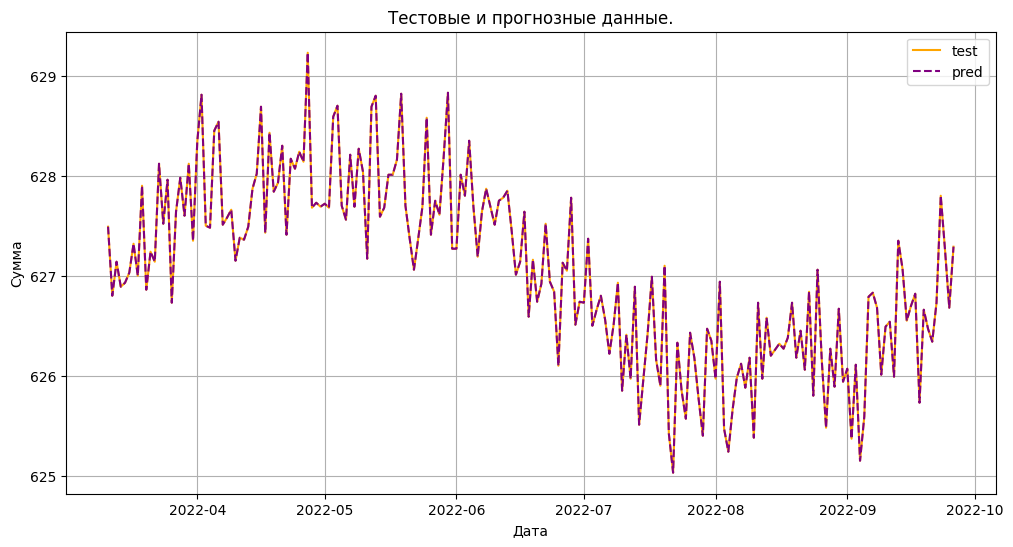

In [335]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.index, y_test['total_feature'], color='orange', label='test', linestyle='-')
plt.plot(y_pred.index, y_test['total_feature'], color='purple', label='pred', linestyle='--')

plt.title(f'Тестовые и прогнозные данные.')
plt.xlabel('Дата')
plt.ylabel('Сумма')

plt.grid()
plt.legend()
plt.show()